<div align = 'center'>
    <img src="../images/ga_logo_large.png">
</div>

---
## **Project 3: Web APIs and NLP**

----
### **Pre Processing and Model Training**

In [413]:
# import libraries needed for this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# metrics
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay)

In [16]:
# read in clean file
file_path = '../data/clean_data/reddit.csv'

reddit = pd.read_csv(file_path)

# check dimensions and a couple rows
print(reddit.shape)
reddit.tail(2)

(2226, 7)


,post_title,post_text,post_title_length,post_title_wc,post_text_length,post_text_wc,topic
2224,Argentina: Buenos Aires or Salta for 3-4 extra...,Hello...I am taking a group tour in Argentina ...,51,9,1568,304,1
2225,First time investing in Duplex,"Hey guys, really need some advice as it is my ...",30,5,533,98,0


This dataset is already clean, there are no missing values or duplicates.  Let's proceed to pre-processing.

---
**Pre-Processing Stage**<br>
Set up _**X**_ matrix and **y** target vector

From the EDA stage, it was determined that the classifier we're about to build will rely on data from the `post_title` column.  The target will be the `topic` column, where a value of `0` means the row contains a real estate post, and a value of `1` means the row contains a travel post.  The aim of the classifier is to predict whether any given post is a travel post or not.

In [30]:
# set up matrix and target
X = reddit['post_title']
y = reddit['topic']

# confirm shapes
X.shape, y.shape

((2226,), (2226,))

**Calculate Baseline Accuracy**

In [34]:
y.value_counts(normalize = True)

topic
1    0.515274
0    0.484726
Name: proportion, dtype: float64

In [47]:
base_acc = y.value_counts(normalize = True)[1]

In [67]:
print(f"The classes are very well balanced in this dataset. Travel posts account for {round(base_acc, 3)*100}% of the data.\n"
"The various models that will be attempted need to beat this level of accuracy.")

The classes are very well balanced in this dataset. Travel posts account for 51.5% of the data.
The various models that will be attempted need to beat this level of accuracy.


**Training and Testing Set Splits**

In [82]:
# use 70/30 split
# although classes are almost evenly balanced, I will still stratify the data to keep the same ratio
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.7,
                                                    stratify = y,
                                                    random_state = 1976)

In [84]:
# confirm stratification
print(y_train.value_counts(normalize = True))
print('*'*35)
print(y_test.value_counts(normalize = True))

topic
1    0.515404
0    0.484596
Name: proportion, dtype: float64
***********************************
topic
1    0.51497
0    0.48503
Name: proportion, dtype: float64


Both the training set and the testing set are set up and balanced correctly to mimic the original data.

---
**Model Buildup, Training and Evaluation Stage**

Use function below to quickly evaluate models.

In [471]:
def evaluate_model(model, X_test = X_test, y_test = y_test):

    # calculate metrics for current model design/iteration------------------------
    preds = model.predict(X_test)
    
    acc1 = round(model.best_score_, 3)                # best accuracy score
    acc2 = round(model.score(X_test, y_test), 3)      # actual accuracy score on test set
    mis = round(1 - acc2, 3)                          # misclassification rate on test set
    prec = round(precision_score(y_test, preds), 3)   # precision score
    f1 = round(f1_score(y_test, preds), 3)            # f1 score
    # ----------------------------------------------------------------------------
    
    # plot confusion matrix and ROC curve-----------------------------------------
    
    # container
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # source to tweak with the confusion matrix parameters: 
    # https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                          display_labels = ['Real Estate', 'Travel'],
                                          ax = axes[0], colorbar = False,
                                          cmap = 'Blues')


    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1],
                                   color = '#00bcd4');

    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)


    plt.legend(frameon = False, loc = 'lower right')

    # source for this line: 
    # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots
    plt.subplots_adjust(wspace=0.4)
    #---------------------------------------------------------------------------------
    
    
    # print statements----------------------------------------------------------------
    print(f'Best Accuracy Score: {acc1}')
    print(f'Actual Accuracy Score: {acc2}')
    print(f'Misclassification Rate: {mis}')
    print(f'Precision Score: {prec}')
    print(f'F1 Score: {f1}')
    #---------------------------------------------------------------------------------
    
    # save plots
    
    
    return {'best_accuracy': acc1, 
            'accuracy': acc2,
            'misclassification': mis,
            'precision': prec,
            'f1_score': f1
           }    

The list below will store the metrics returned from the `evaluate_model()` function.

In [473]:
metrics = []

**Model 1**

In [89]:
# use Logistic Regression with Count Vectorizer
# build pipeline
pipe1 = Pipeline([
    ('cvec1', CountVectorizer()),
    ('model1', LogisticRegression())
])

In [145]:
# grid search parameters
params1 = {'cvec1__stop_words': [None, 'english'],
           'cvec1__max_features': [None, 1000, 5000, 10000],
           'model1__penalty': [None, 'l2']}

In [147]:
# grid search setup
gs1 = GridSearchCV(
    pipe1,
    param_grid = params1,
    n_jobs = -1,
    verbose = 1
)

In [149]:
# fit model
gs1.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('cvec1', CountVectorizer()),
                                       ('model1', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec1__max_features': [None, 1000, 5000, 10000],
                         'cvec1__stop_words': [None, 'english'],
                         'model1__penalty': [None, 'l2']},
             verbose=1)

**Model 1 Evaluation**

In [422]:
# best params
print(gs1.best_params_)

{'cvec1__max_features': None, 'cvec1__stop_words': 'english', 'model1__penalty': 'l2'}


In [420]:
# training score
print(gs1.score(X_train, y_train))

0.996790757381258


Best Accuracy Score: 0.919
Actual Accuracy Score: 0.916
Misclassification Rate: 0.084
Precision Score: 0.9
F1 Score: 0.92


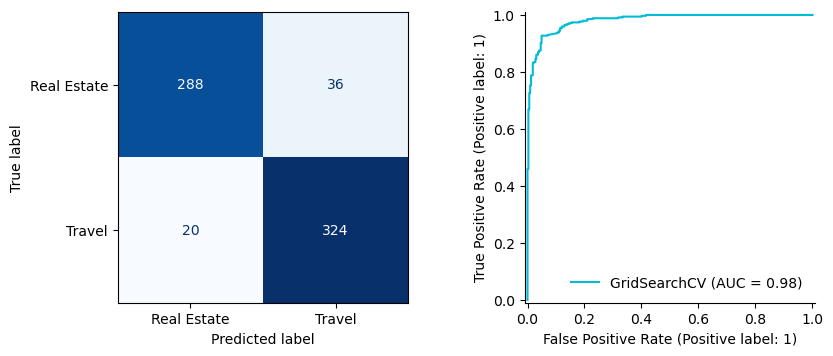

In [461]:
metrics.append(evaluate_model(gs1))

In [ ]:
metrics